# Model traing with All Batches

1. Load the tokenizer

In [5]:
import sys
sys.path.append('..')

In [6]:
#his code sets up a tokenizer by loading a pre-trained model and provides a utility
#function to determine the total number of unique tokens the tokenizer understands

from minbpe.basic import BasicTokenizer

tokenizer = BasicTokenizer()
tokenizer.load(model_file="/content/TRAIN_MODEL/tokenizer/my_tokenizer.model")


def get_vocab_size(tokenizer: BasicTokenizer) -> int:
    vocab = tokenizer.vocab
    special_tokens = tokenizer.special_tokens

    return len(vocab) + len(special_tokens)

2. Create the model

In [7]:
import torch
torch.manual_seed(3647)

# Setting a seed ensures that operations that involve randomness (like initializing weights in a neural network)
#will produce the same results each time the code is run with the same seed.
#The number 3647 is the specific seed value being used.

In [8]:
#passing the hyper-parameter to the GPT1 Model for computation
from transformer.model import GPTLanguageModel

block_size = 256
n_embd = 516
n_head = 12
n_layer = 4
dropout = 0.2
batch_size = 64
vocab_size = get_vocab_size(tokenizer)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = GPTLanguageModel(
    vocab_size=vocab_size,
    block_size=block_size,
    n_embd=n_embd,
    n_head=n_head,
    n_layer=n_layer,
    dropout=dropout,
    device=device
).to(device)
model = torch.compile(model)

print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

13.474826 M parameters


# Data preparation


1. Load the data


In [9]:
# this code loads text data from a file, converts it into a sequence of numerical tokens using a pre-trained tokenizer,
#and then prints the total number of tokens in the resulting sequence

with open("/content/TRAIN_MODEL/output/combined_text.txt", "r") as f:
    text_sequence = f.read()

encoded_text_sequence = tokenizer.encode(text_sequence)
len(encoded_text_sequence)

669641

2. Split it into train and test

In [10]:
#This code converts your tokenized data into a PyTorch tensor and then splits that tensor into two sets:
#one for training your model and one for validating its performance

data = torch.tensor(encoded_text_sequence, dtype=torch.long)
split_index = int(0.9*len(data))
train_data = data[:split_index]
val_data = data[split_index:]

3. Data loader

In [11]:
from typing import Tuple
from torch.utils.data import Dataset, DataLoader


class TextDataset(Dataset):
    def __init__(self, data: torch.Tensor, block_size: int) -> None:
        self.data = data
        self.block_size = block_size

    def __len__(self) -> int:
        return len(self.data) - self.block_size

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        x = self.data[index:index + self.block_size]
        y = self.data[index + 1:index + self.block_size + 1]
        return x, y


def get_dataloaders(
        train_data: torch.Tensor,
        val_data: torch.Tensor,
        block_size: int,
        batch_size: int,
        device: torch.device
) -> Tuple[DataLoader, DataLoader]:
    train_dataset = TextDataset(train_data.to(device), block_size)
    val_dataset = TextDataset(val_data.to(device), block_size)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, val_loader

    #This code defines a custom dataset class to handle the sequential nature of text data for language modeling and
    #provides a convenient function to create data loaders that will be used to feed batches of this data to your model during training and evaluation

In [12]:
# this code creates the data loaders using the previously defined function and then retrieves and displays the shape of a sample batch from the training data loader.
#This is often done to verify that the data is being loaded and batched correctly before starting the training process

train_loader, val_loader = get_dataloaders(
    train_data=train_data,
    val_data=val_data,
    block_size=block_size,
    batch_size=batch_size,
    device=device
)
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([64, 256]), torch.Size([64, 256]))

4. Training

In [13]:
#this code defines a function that efficiently estimates the performance of your language model on a subset of the training and validation data by calculating the average loss without computing gradients.
#This function is typically called periodically during training to monitor the model's progress and detect overfitting.

from typing import Dict


@torch.no_grad()
def estimate_loss(
    model: torch.nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    eval_iters: int
) -> Dict[str, float]:
    output = {}
    model.eval()

    for split, loader in [('train', train_loader), ('val', val_loader)]:
        losses = torch.zeros(eval_iters)
        for i, (x, y) in enumerate(loader):
            if i >= eval_iters:
                break
            with torch.no_grad():
                _, loss = model(x, y)
            losses[i] = loss.item()
        output[split] = losses.mean().item()

    model.train()
    return output

In [14]:
#this code defines a function that packages the essential training information (model parameters, optimizer state, epoch, and loss)
#into a dictionary and saves it to a file, allowing you to easily resume training or use the trained model later

def save_checkpoint(
    model: GPTLanguageModel,
    optimizer: torch.optim.Optimizer,
    epoch: int,
    loss: float,
    file_path: str = "checkpoint.pth"
) -> None:
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, file_path)

In [16]:
# this code defines the core training process for your language model, including hyperparameter settings,
#optimizer initialization, data loading, iterative training steps, periodic evaluation, early stopping based on
#validation loss, and saving model checkpoints.

max_iters = 10
eval_interval = 50
eval_iters = 200
learning_rate = 3e-4
patience = 3

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
train_loader, val_loader = get_dataloaders(
    train_data=train_data,
    val_data=val_data,
    block_size=block_size,
    batch_size=batch_size,
    device=device
)

train_losses = []
val_losses = []
best_val_loss = float('inf')
epochs_without_improvement = 0

for iteration in range(max_iters):
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        # Training step
        logits, loss = model(x_batch, y_batch)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        if batch_idx % eval_interval == 0 or batch_idx == len(train_loader) - 1:
            losses = estimate_loss(
                model=model,
                train_loader=train_loader,
                val_loader=val_loader,
                eval_iters=min(eval_iters, len(val_loader))
            )
            train_losses.append(losses['train'])
            val_losses.append(losses['val'])

            print(
                f"iteration {iteration} / step {batch_idx}: "
                f"train loss {losses['train']:.4f}, "
                f"val loss {losses['val']:.4f}"
            )

            # Early stopping check
            if losses['val'] < best_val_loss:
                best_val_loss = losses['val']
                epochs_without_improvement = 0
                save_checkpoint(model, optimizer, iteration, loss.item(), "best_checkpoint.pth")
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print(f"Early stopping triggered at epoch {iteration}")
                    break


    save_checkpoint(
        model=model,
        optimizer=optimizer,
        epoch=iteration,
        loss=loss.item(),
        file_path=f"/content/TRAIN_MODEL/output/checkpoint_{iteration}.pth"
    )

    if epochs_without_improvement >= patience:
        break

iteration 0 / step 0: train loss 6.6553, val loss 6.6367
iteration 0 / step 50: train loss 4.0925, val loss 4.2308
iteration 0 / step 100: train loss 2.4586, val loss 2.8926
iteration 0 / step 150: train loss 1.8875, val loss 2.4077
iteration 0 / step 200: train loss 1.6662, val loss 2.1819
iteration 0 / step 250: train loss 1.5472, val loss 2.0856
iteration 0 / step 300: train loss 1.4235, val loss 2.0020
iteration 0 / step 350: train loss 1.3201, val loss 1.9887
iteration 0 / step 400: train loss 1.3004, val loss 1.9695
iteration 0 / step 450: train loss 1.2582, val loss 1.9494
iteration 0 / step 500: train loss 1.1773, val loss 1.9189
iteration 0 / step 550: train loss 1.1300, val loss 1.9860
iteration 0 / step 600: train loss 1.0876, val loss 1.9095
iteration 0 / step 650: train loss 1.0454, val loss 1.9221
iteration 0 / step 700: train loss 1.0198, val loss 1.9165
iteration 0 / step 750: train loss 0.9843, val loss 1.8571
iteration 0 / step 800: train loss 0.9487, val loss 1.8864


✅ Final Assessment:
 1. your model has learned well — both losses dropped significantly.
 2. Validation loss leveled off, so early stopping was correct.
 3. You have a well-trained model with good generalization for this epoch

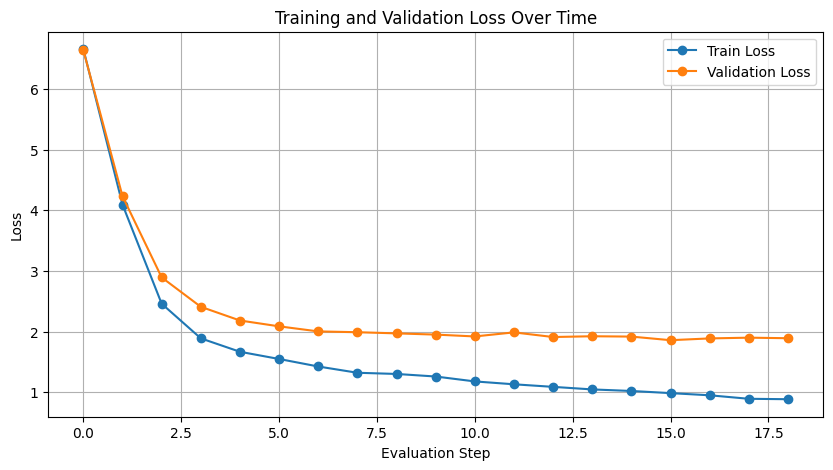

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='o')
plt.xlabel("Evaluation Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Time")
plt.legend()
plt.grid()
plt.show()

In [ ]:
#This code takes a starting phrase, feeds it to your trained language model,
#and the model generates a continuation of that text

input_tokens = tokenizer.encode("come my area bro")
input_tokens = torch.tensor(
    input_tokens, dtype=torch.long).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model.generate(input_tokens=input_tokens, max_new_tokens=100)

print(tokenizer.decode(output[0].tolist()))